In [1]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Missing data and rerun EDA
- handle missing data 
- rerun through the eda steps with clean data
- run boruta analysis for feature selection

In [2]:
# ------------ handle missing data ------------
# overall
# inspect dataset
radiomics_df = pd.read_csv("../motum/merged_radiomics_data.csv")
radiomics_df['modality'] = radiomics_df['Image'].str.extract(r"/([^/]+)\.nii\.gz$")[0]
radiomics_df['modality'].unique()
print(radiomics_df.shape)
print(radiomics_df.head())

print(radiomics_df.isna().sum())

feat_families = {}
feat_cols = []
for c in radiomics_df.columns:
    if c.startswith("original_"): # only looking at num feats
        fam = c.split("_")[1]
        feat_families[fam] = feat_families.get(fam, 0) + 1
        feat_cols.append(c)

# no of feats in each family
print(feat_families)
print(feat_cols)

# groupby by modality
na_by_mod = radiomics_df.groupby("modality")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"avg NA across features (by modality):\n {na_by_mod}")

# group by subject
na_by_subj = radiomics_df.groupby("subject_id")[feat_cols].apply(
    lambda df: df.isna().mean(axis=0).mean()
)
print(f"\navg NA across features (by subject):\n{na_by_subj}")
print(f"\nThese subjects are have most NA:{na_by_subj[na_by_subj > 0.25]}")

(268, 140)
                                               Image  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

                                                Mask  \
0  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
1  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
2  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
3  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   
4  /hdd3/bran/data/SD_glioma/submitted_data/MOTUM...   

  diagnostics_Versions_PyRadiomics diagnostics_Versions_Numpy  \
0                           v3.0.1                     1.19.5   
1                           v3.0.1                     1.19.5   
2                           v3.0.1                     1.19.5   
3                              NaN                     

In [3]:
# remove t1ce and subjects with high missingness
print(radiomics_df.shape)
subj_to_drop = ["sub-0024", "sub-0048", "sub-0057"]
df = radiomics_df[
    (radiomics_df["modality"] != "t1ce") &
    (~radiomics_df['subject_id'].isin(subj_to_drop))
    ] 
print(df.shape)

# overall
print(df.isna().sum())

(268, 140)
(192, 140)
Image                               0
Mask                                0
diagnostics_Versions_PyRadiomics    0
diagnostics_Versions_Numpy          0
diagnostics_Versions_SimpleITK      0
                                   ..
FlipAngle                           7
SliceThickness                      7
PixelSpacing                        7
subject_id                          0
modality                            0
Length: 140, dtype: int64


In [4]:
## Concatenate multimodal radiomics data 
# Pivot to wide format
df_wide = (
    df
    .set_index(["subject_id", "modality"])[feat_cols]
    .unstack("modality")   # turn modality values into column groups
)

# flatten multi-index column names: f1 -> f1_flair, f1_t2, ...
df_wide.columns = [f"{feat}_{mod}" for feat, mod in df_wide.columns]
df_final = df_wide.reset_index()

# merge with metadata on subject_id
meta_df = pd.read_csv("../motum/Participants_wlabels.csv")
meta_headers = list(meta_df.columns)
merge_df = df_final.merge(meta_df, how='left', left_on='subject_id', right_on='ID', validate='many_to_one')
print(merge_df.shape)
print(merge_df.columns)


(64, 341)
Index(['subject_id', 'original_shape_Elongation_flair',
       'original_shape_Elongation_t1', 'original_shape_Elongation_t2',
       'original_shape_Flatness_flair', 'original_shape_Flatness_t1',
       'original_shape_Flatness_t2', 'original_shape_LeastAxisLength_flair',
       'original_shape_LeastAxisLength_t1',
       'original_shape_LeastAxisLength_t2',
       ...
       'Ki-67', 'Olig-2', 'surg_or_biop', 'EOR', 'molec_result',
       'flair_img_rating', 't1_img_rating', 't1ce_img_rating', 't2_img_rating',
       'label'],
      dtype='object', length=341)


majority of missingness is associated with t1ce and the subjects sub-0024, sub-0048 and sub-0057
drop these for downstream consideration

### Rerun through eda steps and investigate missing values:

At this stage, the data is clean of most NAs. We are going to perform a bit more data cleaning:
- rename the variables to clean it up names (drop original_)
- create correlation plots

In [5]:
feat_families = {}
feat_cols = []
for c in merge_df.columns:
    if c.startswith("original_"): # only looking at num feats
        fam = c.split("_")[1]
        feat_families[fam] = feat_families.get(fam, 0) + 1
        feat_cols.append(c)

# remove prefixes
merge_df.columns = merge_df.columns.str.removeprefix("original_")
rad_feat_cols = [c.replace("original_", "", 1) for c in feat_cols]
print(rad_feat_cols)

rad_feat_df = merge_df[rad_feat_cols]

# # correlation matrix
corr = rad_feat_df.corr()
# corr.to_csv("../motum/correlation_results.csv", index=False, na_rep="NA")

['shape_Elongation_flair', 'shape_Elongation_t1', 'shape_Elongation_t2', 'shape_Flatness_flair', 'shape_Flatness_t1', 'shape_Flatness_t2', 'shape_LeastAxisLength_flair', 'shape_LeastAxisLength_t1', 'shape_LeastAxisLength_t2', 'shape_MajorAxisLength_flair', 'shape_MajorAxisLength_t1', 'shape_MajorAxisLength_t2', 'shape_Maximum2DDiameterColumn_flair', 'shape_Maximum2DDiameterColumn_t1', 'shape_Maximum2DDiameterColumn_t2', 'shape_Maximum2DDiameterRow_flair', 'shape_Maximum2DDiameterRow_t1', 'shape_Maximum2DDiameterRow_t2', 'shape_Maximum2DDiameterSlice_flair', 'shape_Maximum2DDiameterSlice_t1', 'shape_Maximum2DDiameterSlice_t2', 'shape_Maximum3DDiameter_flair', 'shape_Maximum3DDiameter_t1', 'shape_Maximum3DDiameter_t2', 'shape_MeshVolume_flair', 'shape_MeshVolume_t1', 'shape_MeshVolume_t2', 'shape_MinorAxisLength_flair', 'shape_MinorAxisLength_t1', 'shape_MinorAxisLength_t2', 'shape_Sphericity_flair', 'shape_Sphericity_t1', 'shape_Sphericity_t2', 'shape_SurfaceArea_flair', 'shape_SurfaceA

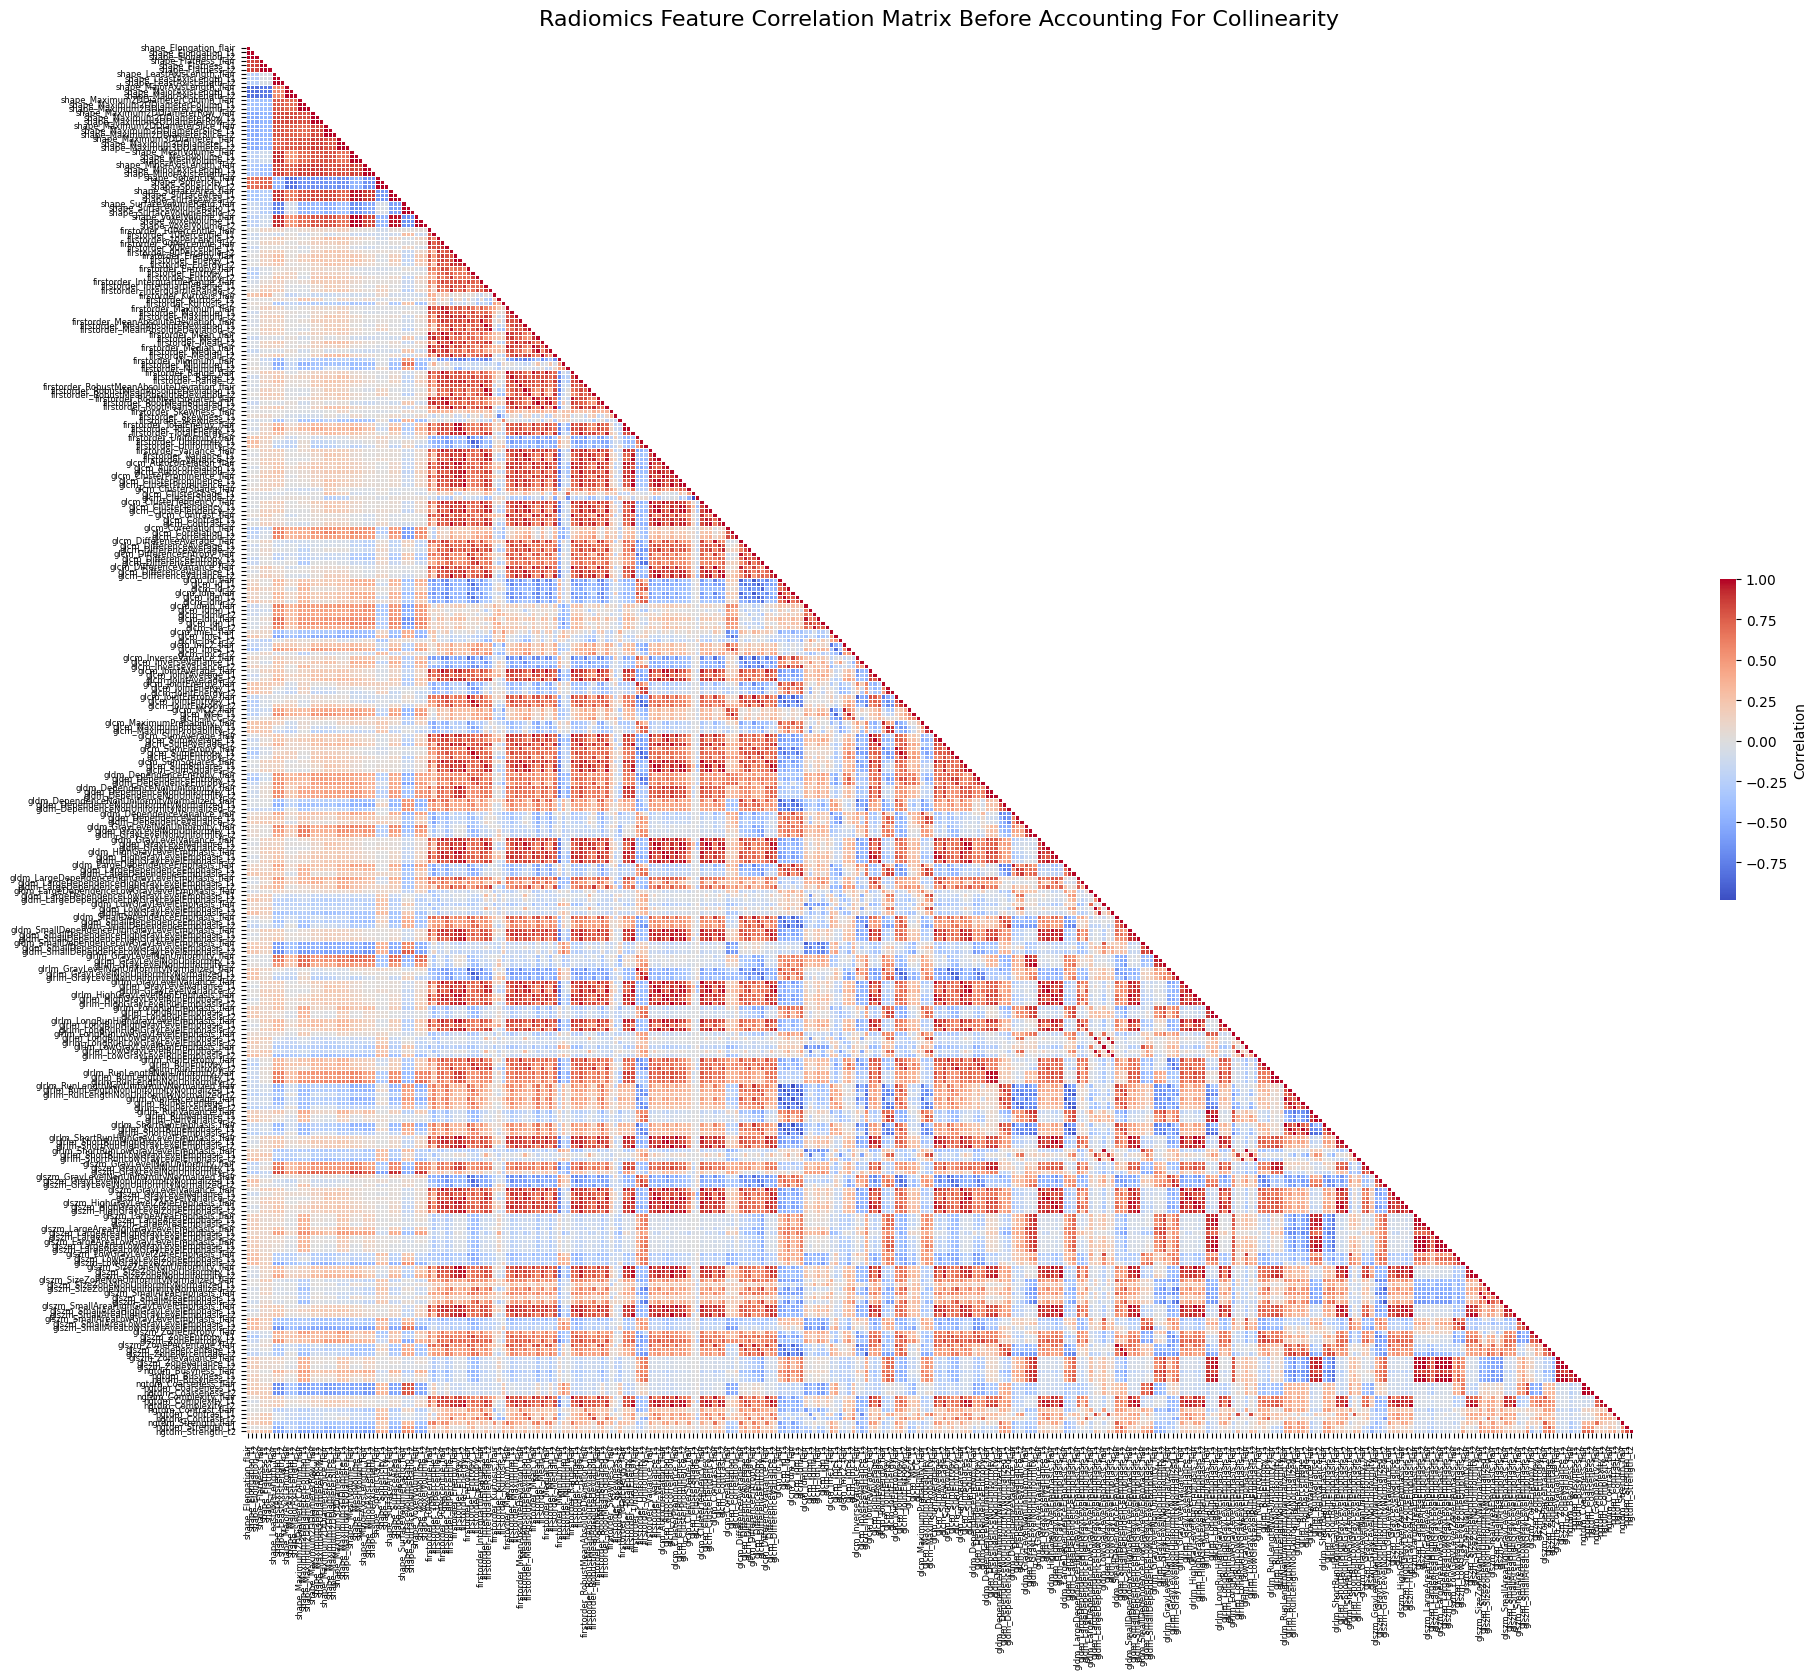

In [6]:
def get_lower_tri_heatmap(df):
    #https://stackoverflow.com/questions/2318529/plotting-only-upper-lower-triangle-of-a-heatmap
    mask = np.zeros_like(df, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Want diagonal elements as well
    mask[np.diag_indices_from(mask)] = False

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=(20, 18))

    ax.tick_params(axis='x', labelsize=6)
    ax.tick_params(axis='y', labelsize=6)
    # Draw the heatmap with the mask and correct aspect ratio
    sns_plot = sns.heatmap(df, mask=mask, cmap="coolwarm", center=0,
            square=True, linewidths=.5, cbar_kws={"label": "Correlation", "shrink": 0.2},
            xticklabels=df.columns, yticklabels=df.columns)
    return sns_plot

# generating one heatmap for before we accounted for collinearity
get_lower_tri_heatmap(corr)
plt.title("Radiomics Feature Correlation Matrix Before Accounting For Collinearity", fontsize=16, pad=15)
plt.tight_layout()
plt.show()

## Feature Engineering


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
from sklearn.model_selection import train_test_split

Perform train-test split before performing collinearity analyses and feature selection.

In [ ]:
rad_feat_cols.append("subject_id")
print(rad_feat_cols)
X_rad = merge_df[rad_feat_cols]
# X_clin = df[meta_cols]
y = merge_df['label']

# subject ID and label df
subject_df = merge_df[['subject_id', 'label']].drop_duplicates()

# doing a train test split accounting 
train_subjects, test_subjects = train_test_split(
    subject_df['subject_id'],
    test_size=0.2,
    random_state=42,
    stratify=subject_df['label']     
)

# mask full data for train/test subjects
train_mask = merge_df['subject_id'].isin(train_subjects)
test_mask = merge_df['subject_id'].isin(test_subjects)
X_rad_train, X_rad_test = X_rad[train_mask], X_rad[test_mask]
# X_clin_train, X_clin_test = X_clin[train_mask], X_clin[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# making sure the split was conducted as intended
print(len(y_train))
print(len(y_test))
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

# drop subject id
X_rad_sub_train = X_rad_train.drop("subject_id", axis=1)
X_rad_sub_test = X_rad_test.drop("subject_id", axis=1)

['shape_Elongation_flair', 'shape_Elongation_t1', 'shape_Elongation_t2', 'shape_Flatness_flair', 'shape_Flatness_t1', 'shape_Flatness_t2', 'shape_LeastAxisLength_flair', 'shape_LeastAxisLength_t1', 'shape_LeastAxisLength_t2', 'shape_MajorAxisLength_flair', 'shape_MajorAxisLength_t1', 'shape_MajorAxisLength_t2', 'shape_Maximum2DDiameterColumn_flair', 'shape_Maximum2DDiameterColumn_t1', 'shape_Maximum2DDiameterColumn_t2', 'shape_Maximum2DDiameterRow_flair', 'shape_Maximum2DDiameterRow_t1', 'shape_Maximum2DDiameterRow_t2', 'shape_Maximum2DDiameterSlice_flair', 'shape_Maximum2DDiameterSlice_t1', 'shape_Maximum2DDiameterSlice_t2', 'shape_Maximum3DDiameter_flair', 'shape_Maximum3DDiameter_t1', 'shape_Maximum3DDiameter_t2', 'shape_MeshVolume_flair', 'shape_MeshVolume_t1', 'shape_MeshVolume_t2', 'shape_MinorAxisLength_flair', 'shape_MinorAxisLength_t1', 'shape_MinorAxisLength_t2', 'shape_Sphericity_flair', 'shape_Sphericity_t1', 'shape_Sphericity_t2', 'shape_SurfaceArea_flair', 'shape_SurfaceA

Performing collinearity analysis and removing redundant features

In [8]:
# Perform collinearity analysis ONLY on training features
print(X_rad_sub_train.shape)
corr_train = X_rad_sub_train.corr()

# filtering for correlation threshold
corr_threshold = 0.9
abs_corr = corr_train.abs()

# identify all correlated pairs above threshold
upper_tri = abs_corr.where(
    np.triu(np.ones(abs_corr.shape), k=1).astype(bool)
)

# find all correlated pairs
correlated_pairs = []
for column in upper_tri.columns:
    correlated_features = upper_tri.index[upper_tri[column] > corr_threshold].tolist()
    for feature in correlated_features:
        correlated_pairs.append((column, feature, upper_tri.loc[feature, column]))

print(f"\nFound {len(correlated_pairs)} correlated pairs above threshold {corr_threshold}:")
for feat1, feat2, corr_value in correlated_pairs[:10]: 
    print(f"  {feat1} <-> {feat2}: {corr_value:.3f}") 

def corr_prune(X: pd.DataFrame, threshold=0.9, method='pearson'):
    """
    Finds pairs of features with the highest |correlation value| and drop the one that is
    more redundant based on mean |correlation value| of each feature with all other features
    it will keep doing that until no pair of features has a correlatino value above the 
    threshold defined in the function returns keep list, drop list, and removal history
    """
    feats = list(X.columns)
    history = []

    # computing absolute pearson correlation
    abs_corr = X.corr(method=method).abs()

    # setting diagonal to zero to make sure that duplicate feature pairs don't impact this analysis
    np.fill_diagonal(abs_corr.values, 0.0)

    # list of feature names
    active = feats.copy()

    while True:
        # upper-triangular max
        upper = np.triu(abs_corr.values, k=1)
        max_val = upper.max()
        if not np.isfinite(max_val) or max_val < threshold:
            break

        # take one max pair
        i_idx, j_idx = np.where(upper == max_val)
        i, j = int(i_idx[0]), int(j_idx[0])
        fi, fj = abs_corr.index[i], abs_corr.columns[j]

        # calculating mean |r| to others (excluding self)
        mean_i = abs_corr.loc[fi].drop(fi).mean()
        mean_j = abs_corr.loc[fj].drop(fj).mean()

        # drop more redundant - account for cases where the means are equal
        drop_feat = fi if (mean_i > mean_j or (mean_i == mean_j and fi > fj)) else fj
        keep_feat = fj if drop_feat == fi else fi

        history.append(
            (keep_feat, drop_feat, 
                float(max_val), 
                float(mean_i) if keep_feat == fi else float(mean_j),
                float(mean_j) if drop_feat == fj else float(mean_i)
            )
        )

        # remove feature from matrix
        active.remove(drop_feat)
        abs_corr = abs_corr.drop(index=drop_feat, columns=drop_feat)

    keep = active
    drop = [f for f in feats if f not in set(keep)]
    return keep, drop, history

# run this function to remove highly correlated pairs of features
keep_feats, drop_feats, removal_history = corr_prune(X_rad_sub_train)

# subset features accordingly
X_rad_sub_train_pruned = X_rad_sub_train[keep_feats]
X_rad_sub_test_pruned = X_rad_sub_test[keep_feats]
rad_feat_cols_pruned = keep_feats 

print(f"Started with {X_rad_sub_train.shape[1]} features; kept {len(rad_feat_cols_pruned)}, dropped {len(drop_feats)} at |r| >= 0.9 using Pearson.")

# # save the removal history
# pd.DataFrame(removal_history, columns=["kept","dropped","max_abs_r","mean_abs_r_kept","mean_abs_r_dropped"])\
#   .to_csv("../motum/corr_prune_history.csv", index=False)


(51, 321)

Found 1959 correlated pairs above threshold 0.9:
  shape_Elongation_t1 <-> shape_Elongation_flair: 1.000
  shape_Elongation_t2 <-> shape_Elongation_flair: 1.000
  shape_Elongation_t2 <-> shape_Elongation_t1: 1.000
  shape_Flatness_t1 <-> shape_Flatness_flair: 1.000
  shape_Flatness_t2 <-> shape_Flatness_flair: 1.000
  shape_Flatness_t2 <-> shape_Flatness_t1: 1.000
  shape_LeastAxisLength_t1 <-> shape_LeastAxisLength_flair: 1.000
  shape_LeastAxisLength_t2 <-> shape_LeastAxisLength_flair: 1.000
  shape_LeastAxisLength_t2 <-> shape_LeastAxisLength_t1: 1.000
  shape_MajorAxisLength_t1 <-> shape_MajorAxisLength_flair: 1.000
Started with 321 features; kept 102, dropped 219 at |r| >= 0.9 using Pearson.


Data is clean and collated as meta_df (rad_feat_df if radiomics data only). The radiomics columns are rad_feat_cols while the metadata cols are meta_headers.

In [9]:
# rad_feat_cols
for i in rad_feat_cols_pruned:
    print(i)

# note all shape features are identical or highly correlated across samples
#  (not that flair is more unique)

shape_Elongation_flair
shape_Flatness_flair
shape_LeastAxisLength_flair
shape_MajorAxisLength_flair
shape_Maximum2DDiameterColumn_flair
shape_Maximum2DDiameterRow_flair
shape_Maximum2DDiameterSlice_flair
shape_Maximum3DDiameter_flair
shape_MinorAxisLength_flair
shape_Sphericity_flair
shape_SurfaceArea_flair
shape_SurfaceVolumeRatio_flair
firstorder_10Percentile_flair
firstorder_10Percentile_t1
firstorder_InterquartileRange_flair
firstorder_Kurtosis_flair
firstorder_Kurtosis_t1
firstorder_Kurtosis_t2
firstorder_Maximum_t1
firstorder_Minimum_flair
firstorder_Minimum_t1
firstorder_Minimum_t2
firstorder_RobustMeanAbsoluteDeviation_t1
firstorder_RobustMeanAbsoluteDeviation_t2
firstorder_Skewness_flair
firstorder_Skewness_t1
firstorder_Skewness_t2
firstorder_Uniformity_flair
firstorder_Uniformity_t1
firstorder_Uniformity_t2
glcm_ClusterShade_flair
glcm_ClusterShade_t1
glcm_Correlation_t2
glcm_DifferenceAverage_t2
glcm_Idm_t1
glcm_Idmn_flair
glcm_Idmn_t1
glcm_Idmn_t2
glcm_Idn_t1
glcm_Imc1_fla

In [10]:
print(X_rad_sub_train_pruned.columns)
print(X_rad_sub_test_pruned)
print(rad_feat_cols_pruned)

Index(['shape_Elongation_flair', 'shape_Flatness_flair',
       'shape_LeastAxisLength_flair', 'shape_MajorAxisLength_flair',
       'shape_Maximum2DDiameterColumn_flair',
       'shape_Maximum2DDiameterRow_flair',
       'shape_Maximum2DDiameterSlice_flair', 'shape_Maximum3DDiameter_flair',
       'shape_MinorAxisLength_flair', 'shape_Sphericity_flair',
       ...
       'glszm_ZonePercentage_t1', 'glszm_ZoneVariance_t2',
       'ngtdm_Coarseness_t1', 'ngtdm_Complexity_flair', 'ngtdm_Contrast_flair',
       'ngtdm_Contrast_t1', 'ngtdm_Contrast_t2', 'ngtdm_Strength_flair',
       'ngtdm_Strength_t1', 'ngtdm_Strength_t2'],
      dtype='object', length=102)
    shape_Elongation_flair  shape_Flatness_flair  shape_LeastAxisLength_flair  \
6                 0.804635              0.525699                    34.085866   
7                 0.480152              0.436583                    49.094003   
10                0.637205              0.542822                    50.414564   
14          

In [ ]:
# looking at the rad_feat_df and meta_df
print(rad_feat_df.head())
print(rad_feat_df.shape)
print(X_rad_sub_train_pruned.head())
print(X_rad_sub_train_pruned.shape)
print(meta_df.head())
print(meta_df.shape)

X_rad_sub_train.to_csv("../motum/radiomics_features_for_boruta.csv", index=False, na_rep="NA")
X_rad_sub_train_pruned.to_csv("../motum/radiomics_features_for_boruta_pruned.csv", index=False, na_rep="NA")
meta_df.to_csv("../motum/metadata_file_for_boruta.csv", index=False, na_rep="NA")

   shape_Elongation_flair  shape_Elongation_t1  shape_Elongation_t2  \
0                0.681718             0.681718             0.681718   
1                0.913314             0.913314             0.913314   
2                0.823196             0.823196             0.823196   
3                0.951446             0.951446             0.951446   
4                0.821909             0.821909             0.821909   

   shape_Flatness_flair  shape_Flatness_t1  shape_Flatness_t2  \
0              0.550436           0.550436           0.550436   
1              0.814380           0.814380           0.814380   
2              0.687723           0.687723           0.687723   
3              0.807292           0.807292           0.807292   
4              0.630462           0.630462           0.630462   

   shape_LeastAxisLength_flair  shape_LeastAxisLength_t1  \
0                    43.676621                 43.676621   
1                    26.662496                 26.662496   
2 

Boruta is a python wrapper of the random forest algorithm. It performs a statistical test to assess the importance of features relative to synthetic permutations of features
https://towardsdatascience.com/feature-selection-with-boruta-in-python-676e3877e596/ 

key variables:
- X_rad: radiomics df
- X_met: metadata df
- y: labels (glioma or metastasis)

In [ ]:
rf = RandomForestClassifier(
    n_jobs=-1,
    max_depth=5,
    class_weight='balanced',
    random_state=42
    )
boruta = BorutaPy(
    estimator=rf,
    perc=90,
    n_estimators='auto',
    max_iter=100,
    two_step=True,
    random_state=42,
    )

boruta.fit(X_rad_sub_train_pruned.values, y_train.values)

selected = X_rad_sub_train_pruned.columns[boruta.support_]
print(f"Selected features: {selected}")
print(f"Number of Selected features: {len(selected)}")

Selected features: Index(['shape_Flatness_flair', 'shape_Maximum2DDiameterRow_flair',
       'firstorder_Kurtosis_flair', 'firstorder_Maximum_t1',
       'firstorder_Skewness_flair', 'glcm_InverseVariance_flair',
       'gldm_DependenceNonUniformityNormalized_flair',
       'gldm_DependenceVariance_flair', 'gldm_DependenceVariance_t1',
       'ngtdm_Strength_t2'],
      dtype='object')
Number of Selected features: 10


Initially got no feats tried a few variables to make it less strict - logging doc refs here for report ease later:
- for RandomForestClassifier
    - max_depth: shallower tree

- for Boruta: https://github.com/scikit-learn-contrib/boruta_py 
    - perc: 100 -> 90
    The original method uses the maximum of the shadow features as a threshold in deciding which real feature is doing better than the shadow ones. This could be overly harsh.
    - max_iter: 100 (default) -> 200 (more iter)
    - two_step: False (default) -> True
    The correction for multiple testing was relaxed by making it a two step process, rather than a harsh one step Bonferroni correction.


Possible next steps:
- try decreasing the strictness more or picking feats w less support
- look into other splitting methods (stratified group k fold) if better for our app
- I think boruta does z standardization (?) but maybe we can preprocess data somehow for better signal??

once we select feats we can train model to classify and maybe consider other factors (e.g. centre influence, sex, age, grade etc.)
we should train the model and do cross val (something accounting for stratification by subject so no leakage)

- that should be good for prog report probably 

In [ ]:
# preparing data for pycaret!
# only keeping boruta selected features and adding the target variable back into the dataframe
print(X_rad_train.columns)
train_df = X_rad_train[selected].copy()
train_df["label"] = y_train.values
train_df["subject_id"] = X_rad_train["subject_id"].values

test_df = X_rad_test[selected].copy()
test_df["label"] = y_test.values
test_df["subject_id"] = X_rad_test["subject_id"].values

# save as csv files
train_df.to_csv("../motum/data_for_pycaret_train.csv", index=False, na_rep="NA")
test_df.to_csv("../motum/data_for_pycaret_test.csv", index=False, na_rep="NA")

Index(['shape_Elongation_flair', 'shape_Elongation_t1', 'shape_Elongation_t2',
       'shape_Flatness_flair', 'shape_Flatness_t1', 'shape_Flatness_t2',
       'shape_LeastAxisLength_flair', 'shape_LeastAxisLength_t1',
       'shape_LeastAxisLength_t2', 'shape_MajorAxisLength_flair',
       ...
       'ngtdm_Complexity_flair', 'ngtdm_Complexity_t1', 'ngtdm_Complexity_t2',
       'ngtdm_Contrast_flair', 'ngtdm_Contrast_t1', 'ngtdm_Contrast_t2',
       'ngtdm_Strength_flair', 'ngtdm_Strength_t1', 'ngtdm_Strength_t2',
       'subject_id'],
      dtype='object', length=322)
